Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Sales Data

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

## About the Data

* Check data description and download the data files from https://www.kaggle.com/c/rossmann-store-sales/data?select=store.csv
  * Save downloaded <b>store.csv</b> and <b>store_sales.csv</b> into folder <b>raw_data/</b>  
* This data can be used for regresion and time series problems

In [3]:
store_df = pd.read_csv('raw_data/store.csv', dtype={'CompetitionOpenSinceMonth': 'category', 'CompetitionOpenSinceYear': 'category', 
                                           'Promo2SinceWeek': str, 'Promo2SinceYear': str,
                                          'Store': 'category'})
print(store_df.shape)

store_df.head()

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9,2008,0,NaN,NaN,NaN
1,2,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910.0,4,2015,0,NaN,NaN,NaN


In [4]:
sales_df = pd.read_csv('raw_data/store_sales.csv', dtype={'StateHoliday': 'category', 'DayOfWeek': 'category', 'Store': 'category'}, parse_dates=['Date'])
print(sales_df.shape)

sales_df.head()

(1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
# for stores do not participate promotion, fill their NULL with a special value
store_df[['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']] = store_df[['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']].fillna('-1')

# drop stores without complete competition info, just for simplicity reason
store_df = store_df.dropna(how='any')

print(store_df.shape)

(761, 10)


## Generate Store Sales Data

* Merge store data and sales data
* Check whether there is constant columns, of so remove them
* Convert categorical columns to "category" type
* Add a few more features

In [6]:
store_sales_df = store_df.merge(sales_df, on='Store')
print(store_sales_df.shape)

store_sales_df.head()

(693861, 18)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9,2008,0,-1,-1,-1,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,1270.0,9,2008,0,-1,-1,-1,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,1270.0,9,2008,0,-1,-1,-1,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,1270.0,9,2008,0,-1,-1,-1,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,1270.0,9,2008,0,-1,-1,-1,1,2015-07-27,6102,612,1,1,0,1


In [7]:
# check whether there is close-to-constant column
def get_close_constant_cols(df, threshold=0.99, exclude_cols=[]):
    constant_cols = []
    
    for col in df.columns:
        if col in exclude_cols:
            continue
        if max(df[col].value_counts())/np.sum(df[col].value_counts()) >= threshold:
            constant_cols.append(col)
    return constant_cols

constant_cols = get_close_constant_cols(store_sales_df)
print(constant_cols)

[]


In [8]:
# convert categorical columns to 'category' type with integer values
le = preprocessing.LabelEncoder()
le_cols = ['StoreType', 'Assortment']
int_cat_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

for le_col in le_cols:
    store_sales_df[le_col] = le.fit_transform(store_sales_df[le_col])
    store_sales_df[le_col] = store_sales_df[le_col].astype('category')

for int_cat_col in int_cat_cols:
    store_sales_df[int_cat_col] = store_sales_df[int_cat_col].astype('category')

In [9]:
store_sales_df['Year'] = store_sales_df['Date'].dt.year.astype('category')
store_sales_df['Month'] = store_sales_df['Date'].dt.month.astype('category')
store_sales_df['Quarter'] = (store_sales_df['Date'].dt.month-1)//3+1
store_sales_df['Quarter'] = store_sales_df['Quarter'].astype('category')

store_sales_df = store_sales_df[['Store', 'Date', 'Year', 'Month', 'Quarter',
                                 'StoreType', 'Assortment', 'CompetitionDistance',
                                 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
                                 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek',
                                 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']]

store_sales_df.head()

,Store,Date,Year,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2015-07-31,2015,7,3,2,0,1270.0,9,2008,...,-1,-1,-1,5,5263,555,1,1,0,1
1,1,2015-07-30,2015,7,3,2,0,1270.0,9,2008,...,-1,-1,-1,4,5020,546,1,1,0,1
2,1,2015-07-29,2015,7,3,2,0,1270.0,9,2008,...,-1,-1,-1,3,4782,523,1,1,0,1
3,1,2015-07-28,2015,7,3,2,0,1270.0,9,2008,...,-1,-1,-1,2,5011,560,1,1,0,1
4,1,2015-07-27,2015,7,3,2,0,1270.0,9,2008,...,-1,-1,-1,1,6102,612,1,1,0,1


In [10]:
print(store_sales_df.shape)
store_sales_df.to_pickle('structured_data/sales.pkl')

(693861, 21)


## Generate Time Series Data

### Sales Data (Unvariate Time Series Data)
* There are 761 stores, almost everyday has a sales record for each store
* Aggregate sales by date

In [15]:
store_sales_df = pd.read_pickle('structured_data/sales.pkl')
print(store_sales_df.shape)

store_sales_df.head()

(693861, 21)


,Store,Date,Year,Month,Quarter,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2015-07-31,2015,7,3,2,0,1270.0,9,2008,...,-1,-1,-1,5,5263,555,1,1,0,1
1,1,2015-07-30,2015,7,3,2,0,1270.0,9,2008,...,-1,-1,-1,4,5020,546,1,1,0,1
2,1,2015-07-29,2015,7,3,2,0,1270.0,9,2008,...,-1,-1,-1,3,4782,523,1,1,0,1
3,1,2015-07-28,2015,7,3,2,0,1270.0,9,2008,...,-1,-1,-1,2,5011,560,1,1,0,1
4,1,2015-07-27,2015,7,3,2,0,1270.0,9,2008,...,-1,-1,-1,1,6102,612,1,1,0,1


In [16]:
ts_df = store_sales_df[['Date', 'Sales']]\
        .groupby(['Date'], as_index=False)['Sales']\
        .agg(['sum']).reset_index(drop=True)\
        .sort_values(['Date'], ascending=True)
ts_df = ts_df.rename(index=str, columns={'sum': 'Daily_Sales'})

print(ts_df.shape)
ts_df.head()

(942, 2)


,Date,Daily_Sales
0,2013-01-01,58165
1,2013-01-02,4822042
2,2013-01-03,4415571
3,2013-01-04,4587035
4,2013-01-05,4078281


Text(0, 0.5, 'Daily Sales')

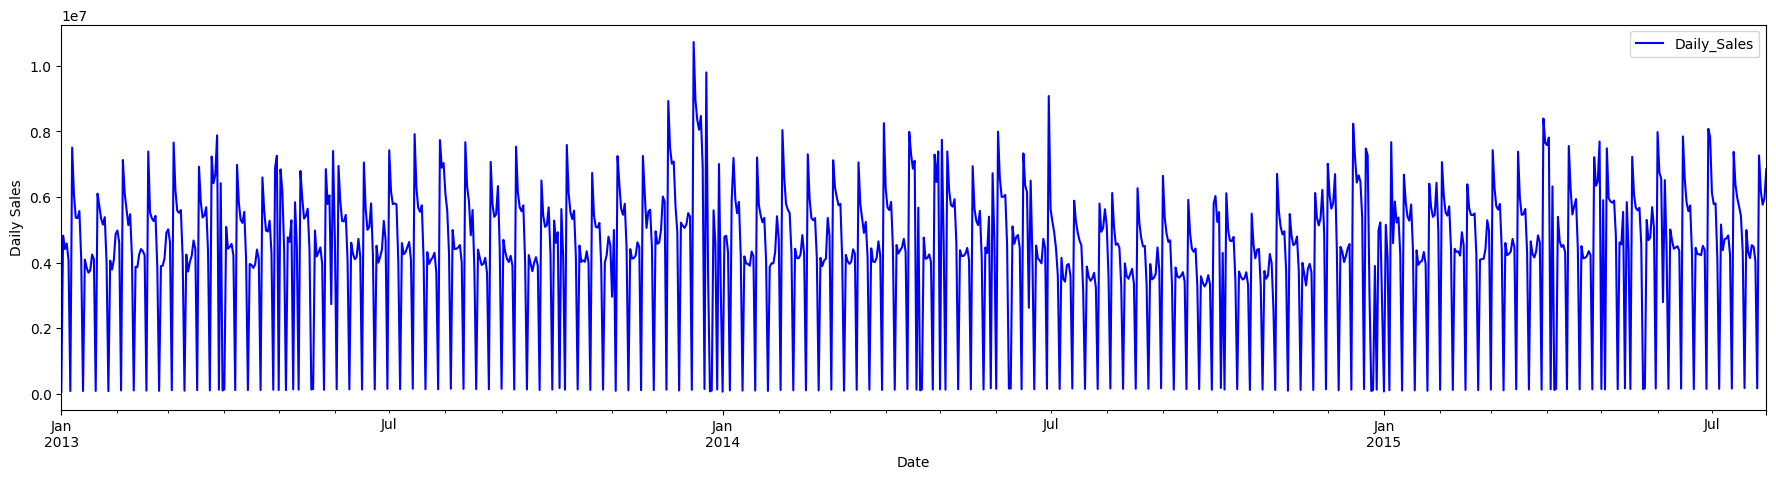

In [17]:
ts_df.plot(x='Date', y='Daily_Sales', figsize=(22,5), color='blue')
plt.ylabel('Daily Sales')

In [18]:
ts_df = ts_df.set_index('Date')

ts_df.head()

,Daily_Sales
Date,
2013-01-01,58165
2013-01-02,4822042
2013-01-03,4415571
2013-01-04,4587035
2013-01-05,4078281


In [19]:
print(ts_df.shape)
ts_df.to_pickle('structured_data/sales_ts.pkl')

(942, 1)
